<a href="https://colab.research.google.com/github/kopildas/project-103/blob/main/platelate_disorder_v5(VotingClassifier).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit, train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import (roc_curve, auc, roc_auc_score, confusion_matrix,
                             classification_report)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading and Pivoting

In [8]:

data = pd.read_excel("/content/drive/MyDrive/project_103/cbc_data.xlsx",
                     sheet_name="cbc data", skiprows=1)
print("Initial Data Shape:", data.shape)

pivot_data = data.pivot_table(
    index=['prescription_ncid', 'patient_name', 'dob'],
    columns='attribute_name',
    values='result',
    aggfunc='first'
).reset_index()

# Define ID and attribute columns separately
id_cols = ['prescription_ncid', 'patient_name', 'dob']
attr_cols = [col for col in pivot_data.columns if col not in id_cols]

# Convert only the CBC attribute columns to numeric
pivot_data[attr_cols] = pivot_data[attr_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows where patient_name is missing (so group-split won't fail)
pivot_data.dropna(subset=['patient_name'], inplace=True)

print("\nPivoted Data Shape:", pivot_data.shape)

Initial Data Shape: (11009, 7)

Pivoted Data Shape: (647, 21)


# 2. Feature Engineering

In [9]:

# Drop rows missing Platelet or MPV (required for ratio calculation)
pivot_data.dropna(subset=['Platelet', 'MPV'], inplace=True)

# Create ratio feature: Platelet_to_MPV
pivot_data['Platelet_to_MPV'] = pivot_data['Platelet'] / pivot_data['MPV']

# Define target based on Platelet thresholds
pivot_data['Platelet_Disorder'] = np.where(
    pivot_data['Platelet'] < 150, 'Thrombocytopenia',
    np.where(pivot_data['Platelet'] > 450, 'Thrombocythaemia', 'Normal')
)

# Numeric encode the target
label_map = {'Thrombocytopenia': 0, 'Thrombocythaemia': 1, 'Normal': 2}
pivot_data['Platelet_Disorder'] = pivot_data['Platelet_Disorder'].map(label_map)

print("\nClass Distribution:")
print(pivot_data['Platelet_Disorder'].value_counts())


Class Distribution:
Platelet_Disorder
2    539
1     48
0     32
Name: count, dtype: int64


# 3. Remove Direct Leakage (Exclude 'Platelet')

In [10]:
# Exclude ID columns, target, and Platelet (for preventing direct leakage)
exclude_cols = ['prescription_ncid', 'patient_name', 'dob', 'Platelet_Disorder', 'Platelet']
feature_columns = [col for col in pivot_data.columns if col not in exclude_cols]
print("\nFeature Columns Used:", feature_columns)


Feature Columns Used: ['Basophils (%)', 'Eosinophils (%)', 'Hemoglobin', 'IG%', 'Lymphocytes (%)', 'MCH', 'MCHC', 'MCV', 'MPV', 'Monocytes (%)', 'Neutrophils (%)', 'PCV/HCT', 'PDW', 'RBC', 'RDW-CV', 'RDW-SD', 'WBC', 'Platelet_to_MPV']


# 4. Group-based Train/Test Split
  ###### to ensure that the same patient does not appear in both training and testing sets.

In [12]:
# Use patient_name to ensure same patient isn't in both sets
groups = pivot_data['patient_name']
X_all = pivot_data[feature_columns].values
y_all = pivot_data['Platelet_Disorder'].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X_all, y_all, groups))

X_train_raw, X_test_raw = X_all[train_idx], X_all[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

# 5. Impute Missing Values & Scale Features

In [13]:
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp = imputer.transform(X_test_raw)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_imp)
X_test = scaler.transform(X_test_imp)

# 6. Feature Selection with RFE
###### (RFE) is applied to select the 10 best features.

In [14]:
rf_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf_for_rfe, n_features_to_select=10)
rfe.fit(X_train, y_train)

selected_mask = rfe.support_
selected_features = np.array(feature_columns)[selected_mask]
print("\nSelected Features (RFE):", selected_features)


Selected Features (RFE): ['MCH' 'MCHC' 'MCV' 'MPV' 'Neutrophils (%)' 'PDW' 'RDW-CV' 'RDW-SD' 'WBC'
 'Platelet_to_MPV']


# 7. Ensemble Model (VotingClassifier)
###### An ensemble of SVC, XGB, Gradient Boosting, and Random Forest is built using soft voting

In [15]:
svc = SVC(kernel='linear', probability=True, random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
gb = GradientBoostingClassifier(random_state=42)
rf_ens = RandomForestClassifier(n_estimators=100, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('svc', svc), ('xgb', xgb), ('gb', gb), ('rf', rf_ens)],
    voting='soft'
)

In [16]:
# Train using only selected features from RFE
voting_clf.fit(X_train[:, selected_mask], y_train)
y_ens_prob = voting_clf.predict_proba(X_test[:, selected_mask])

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:50:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# 8. Evaluation: ROC AUC, Confusion Matrix, Classification Report

In [17]:
# Binarize true labels for ROC computation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
ens_roc_auc_macro = roc_auc_score(y_test_bin, y_ens_prob, average='macro', multi_class='ovr')
print("\nEnsemble Model ROC AUC (Macro-average):", ens_roc_auc_macro)


Ensemble Model ROC AUC (Macro-average): 0.9994887525562373


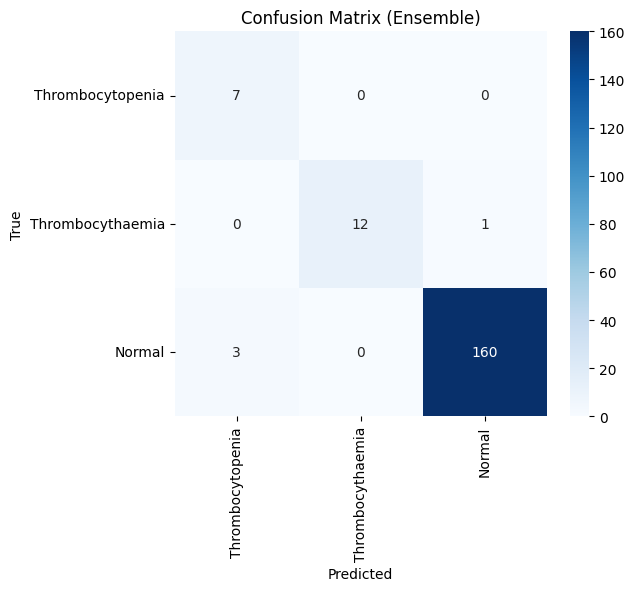

In [18]:
y_ens_pred = voting_clf.predict(X_test[:, selected_mask])
cm = confusion_matrix(y_test, y_ens_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Thrombocytopenia', 'Thrombocythaemia', 'Normal'],
            yticklabels=['Thrombocytopenia', 'Thrombocythaemia', 'Normal'],
            cmap='Blues')
plt.title("Confusion Matrix (Ensemble)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [19]:
print("\nClassification Report:")
print(classification_report(y_test, y_ens_pred,
                            target_names=['Thrombocytopenia', 'Thrombocythaemia', 'Normal']))


Classification Report:
                  precision    recall  f1-score   support

Thrombocytopenia       0.70      1.00      0.82         7
Thrombocythaemia       1.00      0.92      0.96        13
          Normal       0.99      0.98      0.99       163

        accuracy                           0.98       183
       macro avg       0.90      0.97      0.92       183
    weighted avg       0.98      0.98      0.98       183



# 9. Ploting ROC Curves

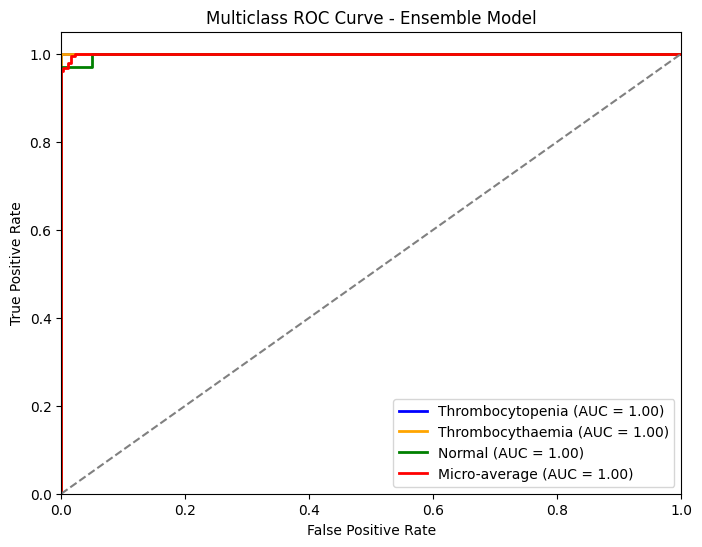

In [20]:
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
class_labels = ['Thrombocytopenia', 'Thrombocythaemia', 'Normal']

# Plot ROC for each class
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_ens_prob[:, i])
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f"{class_labels[i]} (AUC = {roc_auc_val:.2f})")

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_ens_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='red', lw=2,
         label=f"Micro-average (AUC = {roc_auc_micro:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - Ensemble Model')
plt.legend(loc='lower right')
plt.show()

# 10. Cross-Validation with StratifiedKFold

In [21]:
# Re-impute and scale the entire dataset for cross-validation
X_all_imp = imputer.fit_transform(X_all)
X_all_scaled = scaler.fit_transform(X_all_imp)

# Select the same features as determined by RFE
X_sel = X_all_scaled[:, selected_mask]
y_sel = y_all

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ensemble_scores = []

for train_idx_cv, test_idx_cv in skf.split(X_sel, y_sel):
    voting_clf_cv = VotingClassifier(
        estimators=[
            ('svc', SVC(kernel='linear', probability=True, random_state=42)),
            ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
            ('gb', GradientBoostingClassifier(random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
        ],
        voting='soft'
    )
    voting_clf_cv.fit(X_sel[train_idx_cv], y_sel[train_idx_cv])
    y_prob_cv = voting_clf_cv.predict_proba(X_sel[test_idx_cv])
    y_bin_cv = label_binarize(y_sel[test_idx_cv], classes=[0, 1, 2])
    score_cv = roc_auc_score(y_bin_cv, y_prob_cv, average='macro', multi_class='ovr')
    ensemble_scores.append(score_cv)

print("\nCross-Validation Macro-AUC scores:", ensemble_scores)
print("Mean CV Macro-AUC:", np.mean(ensemble_scores))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:10:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:10:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:10:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:10:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:10:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Cross-Validation Macro-AUC scores: [0.9973161776852678, 1.0, 0.9967173242082662, 1.0, 0.9973924187840186]
Mean CV Macro-AUC: 0.9982851841355107
